# Red Neuronal BrandFinder

## Imports

In [1]:
import cv2 as cv
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Función data_evolution

La siguiente función permite visualizar la evolución del rendimiento de un modelo durante el entrenamiento y la validación, proporcionando información sobre la precisión y la pérdida en cada época.

In [30]:
def data_evolution(history):
    plt.subplots_adjust(left = None, bottom = None, right = 1.5, top = None, wspace = 0.5)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.ylim([0.,1.])
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.show()

## Función data_confusion_matrix

La siguiente función calcula y visualiza una matriz de confusión para evaluar el rendimiento de un modelo de clasificación en términos de las etiquetas verdaderas y las etiquetas predichas.

In [33]:
def data_confusion_matrix(validation_generator, labels):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # Generar predicciones en el conjunto de datos de validación
    y_pred = model.predict_generator(validation_generator)

    # Convertir las predicciones en etiquetas de clase (por ejemplo, asignar la clase con mayor probabilidad)
    y_pred = np.argmax(y_pred, axis=1)

    # Obtener las etiquetas reales del conjunto de datos de validación
    y_true = validation_generator.classes

    # Calcular la matriz de confusión
    confusion_mtx = confusion_matrix(y_true, y_pred)
  
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Real')
    plt.show()

## Función image_average

La siguiente dunción calcula el promedio de una lista de números que representa las proporciones de altura/ancho de una colección de imágenes.

In [4]:
def image_average(train_path):

    listdir = os.listdir(train_path)
    ratios_sub = []
    ratios = []

    for imdir in listdir:
        imlist = os.listdir(os.path.join(train_path, imdir))  
        for im in imlist:
            im = cv.imread(os.path.join(train_path,imdir,im))
            ratio = (im.shape[0] / im.shape[1]) #height/width ratio
            ratios_sub.append((ratio))
        ratios_sub_ave= sum(ratios_sub) / len(ratios_sub)
        ratios.append((ratios_sub_ave))
    return sum(ratios) / len(ratios)

    
ratio = image_average("Car_Brand_Logos/Train")

print("Average ratio of width to height is {}".format(ratio))

Average ratio of width to height is 0.8033851860097734


In [5]:
width = 240
height= int(width*ratio)
input_shape = (height,width)
print(input_shape)

(192, 240)


## Definición de variables

In [6]:
img_width, img_height = width, height 
train_data_dir = 'Car_Brand_Logos/Train/'
validation_data_dir = 'Car_Brand_Logos/Test/'

numberOfClass = 8
batch_size = 8
epochs = 12

# Mejorar del rendimiento y generalización del modelo

In [7]:
# Normalización de las imágenes (dividir los valores de píxeles por 255) y aplicación de 
# transformaciones aleatorias a las imágenes de entrenamiento para aumentar la diversidad 
# y cantidad de ejemplos disponibles

train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.90,
    zoom_range = 0.90,
    horizontal_flip = True,
    vertical_flip = True) 

test_datagen = ImageDataGenerator(rescale=1. / 255)

# A continuación, se definen los generadores de lotes, que permiten cargar y procesar las imágenes en lotes 
# más pequeños en lugar de cargar todas las imágenes en la memoria a la vez. 
# Es importante destacar el redimensionamiento de las imágenes a un tamaño específico, utilizando el argumento 
# "target_size", es importante para asegurarse de que todas las imágenes tengan dimensiones uniformes.

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 2513 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


## Definición y entrenamiento del modelo 

In [8]:
# VGG19 es una red neuronal convolucional ampliamente utilizada y entrenada en el conjunto de datos "Imagenet", 
# que contiene una gran cantidad de imágenes clasificadas en diversas categorías.

# Se crea una instancia del modelo VGG19 llamada "vgg" utilizando la función "VGG19" de Keras. Se especifica 
# "include_top=False" para excluir la capa de clasificación final de VGG19, ya que se agregará una capa personalizada
# para la tarea específica. Los pesos se inicializan con los pesos preentrenados en "Imagenet". El argumento "input_shape" 
# especifica el tamaño de entrada de las imágenes que se utilizarán en el modelo.

vgg = VGG19(include_top= False, weights = "imagenet", input_shape=( img_height,img_width, 3))

# "vgg_layer_list" almacena una lista de todas las capas en el modelo VGG19.

vgg_layer_list = vgg.layers

# "model" se utilizará para agregar capas personalizadas.

model = Sequential ()

# Copiaremos todas las capas del modelo VGG19 a "model"

for layer in vgg_layer_list:
    model.add(layer)
    
# Establecer el layer.trainable a False Esto congela los pesos de las capas de VGG19 y evita que se actualicen durante 
# el entrenamiento, lo que significa que solo las capas personalizadas agregadas posteriormente se entrenarán.
    
for layer in model.layers:
    layer.trainable = False
    
# Se agrega una capa "Flatten" para aplanar la salida de la última capa convolucional de VGG19.
    
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))

# El Dropout ayuda a prevenir el sobreajuste al desactivar aleatoriamente algunas neuronas durante el entrenamiento.

model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Se agrega una capa de activación 'softmax' para obtener probabilidades de clasificación para cada clase.

model.add(Dense(numberOfClass))
model.add(Activation('softmax'))

80134624/80134624 [==============================] - 12s 0us/step


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 192, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 120, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 120, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 120, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 60, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 48, 60, 256)       2

A continuación, ce crea una instancia del optimizador Adam llamada "opt" utilizando la clase "Adam" de Keras. Se especifican varios argumentos:

- "lr=0.0001": Especifica la tasa de aprendizaje, que determina el tamaño de los pasos que el algoritmo de optimización toma para ajustar los pesos del modelo durante el entrenamiento. En este caso, se establece en 0.0001.
- "beta_1=0.9": Especifica el valor para el parámetro beta_1 de Adam, que controla el decaimiento exponencial de los promedios móviles de primer orden.
- "beta_2=0.999": Especifica el valor para el parámetro beta_2 de Adam, que controla el decaimiento exponencial de los promedios móviles de segundo orden.

Con el método "compile" del modelo podremos configurar el proceso de entrenamiento. Se especifican varios argumentos:

- "optimizer=opt": Selecciona el optimizador a utilizar durante el entrenamiento. En este caso, se utiliza el optimizador Adam configurado previamente.
- "loss='categorical_crossentropy'": Especifica la función de pérdida que se utilizará para medir la discrepancia entre las etiquetas verdaderas y las predicciones del modelo durante el entrenamiento. En este caso, se utiliza la pérdida de entropía cruzada categórica, que es comúnmente utilizada en problemas de clasificación con múltiples clases.
- "metrics=['accuracy']": Especifica las métricas que se calcularán y mostrarán durante el entrenamiento y la evaluación del modelo. En este caso, se utiliza la métrica de precisión (accuracy) para evaluar el rendimiento del modelo en términos de la clasificación correcta.

In [10]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
hist = model.fit_generator(
        generator=train_generator,        
        epochs=epochs,
        validation_data=validation_generator)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_11828\1850308844.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/12
315/315 [==============================] - 358s 1s/step - loss: 2.4774 - accuracy: 0.1958 - val_loss: 1.8077 - val_accuracy: 0.3475
Epoch 2/12
315/315 [==============================] - 349s 1s/step - loss: 1.8566 - accuracy: 0.2885 - val_loss: 1.5275 - val_accuracy: 0.4575
Epoch 3/12
315/315 [==============================] - 347s 1s/step - loss: 1.7450 - accuracy: 0.3211 - val_loss: 1.4160 - val_accuracy: 0.4800
Epoch 4/12
315/315 [==============================] - 353s 1s/step - loss: 1.6778 - accuracy: 0.3665 - val_loss: 1.3338 - val_accuracy: 0.5075
Epoch 5/12
315/315 [==============================] - 351s 1s/step - loss: 1.6249 - accuracy: 0.3840 - val_loss: 1.3079 - val_accuracy: 0.5700
Epoch 6/12
315/315 [==============================] - 339s 1s/step - loss: 1.5793 - accuracy: 0.4138 - val_loss: 1.2675 - val_accuracy: 0.5575
Epoch 7/12
315/315 [==============================] - 356s 1s/step - loss: 1.5378 - accuracy: 0.4441 - val_loss: 1.3419 - val_accuracy: 0.5525

In [13]:
model.save('modelo.h5')

In [24]:
labels = ["hyundai","lexus","mazda","mercedes","opel","skoda","toyota","volkswagen"]

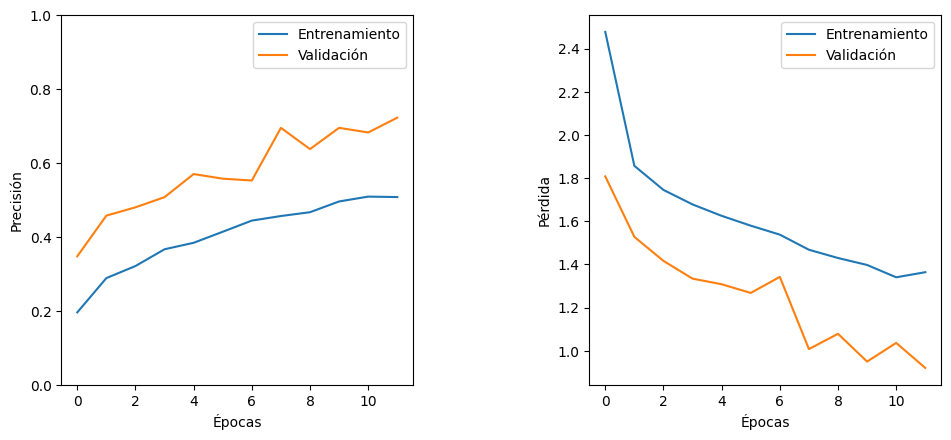

In [21]:
data_evolution(hist)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_11828\2339755702.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(validation_generator)


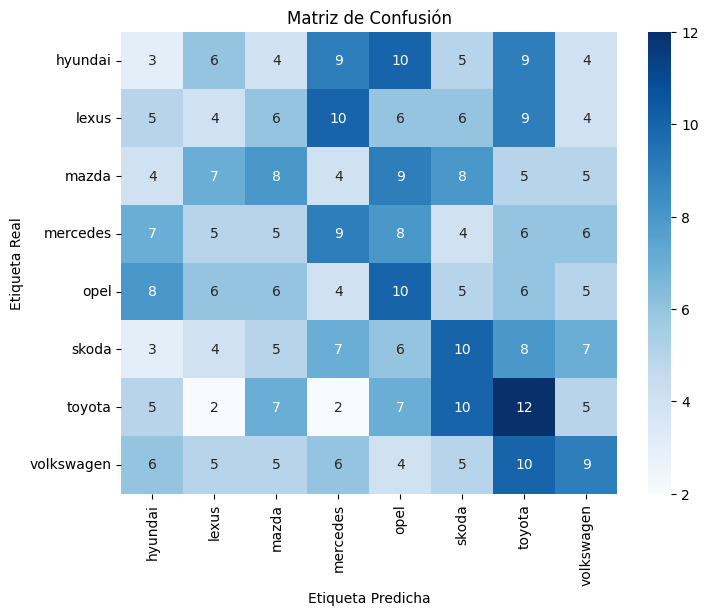

In [35]:
data_confusion_matrix(validation_generator, labels)